In [1]:
#import packages
import pickle
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
from string import punctuation
from gensim import corpora
from collections import Counter
from langdetect import detect_langs
import collections
import math

D:\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Import data, clean data, and transfer to list of words

In [2]:
data = pd.read_csv('../data/trg.csv', header=0,index_col=0)
new_data = pd.read_csv('../data/tst.csv', header=0,index_col=0)

In [3]:
def preprocess(df):
    
    # token and split into list of words
    df_tokens = []
    for i in range(len(df.abstract.values)):
        df_tokens.append(nltk.word_tokenize(df.abstract.values[i]))
        
    # delete stopwords
    df_token_stopwords = []
    for i in range(len(df.abstract.values)):
        df_token_stopwords.append([w for w in df_tokens[i] if w not in stopwords.words('english')])
    df['clean'] = df_token_stopwords
    
    return df


In [4]:
df = preprocess(data)
new_df = preprocess(new_data)

## Split to train, test data

In [5]:
X, y = df,df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Define an accuracy caculator

In [6]:
def cal_accuracy(test, real):
    return np.mean([test[i] == real[i] for i in range(len(real))])

## Simple Naive Bayes Implement


In [7]:
class NaiveBayes():
    
    def __init__(self, df, new_df):
        self.df = df
        self.new_df = new_df
        self.instances_num = df.shape[0]
        self.J = 0

        
    def count_attributes(self):
        """
        count all words in df
        input: df with clean column
        output: cnt dictionary of word list
        """
        cnt = collections.Counter()
        for word in self.df['clean'].values:
            for i in word:
                cnt[i] += 1
        self.count_attributes = cnt
        

 
    def count_class(self):
        """
        count the number of class labels
        input: df with class
        output: cnt dictionary of label
        """
        cnt2 = collections.Counter()
        for i in self.df['class'].values:
            cnt2[i] += 1
        self.count_class = dict(cnt2)


    def count_prior(self):
        """
        count the frequency of words in each class, return a dictionary(four class) of dictionary(words and freqeuncy)
        input: df with class and clean column
        output: list with four lists each for a class
        """
        result_list = {}
        cnt_A = collections.Counter()
        cnt_B = collections.Counter()
        cnt_V = collections.Counter()
        cnt_E = collections.Counter()
        for i in range(len(self.df['class'].values)):
            if self.df['class'].values[i] == 'A':
                for i in self.df['clean'].values[i]:
                    cnt_A[i] += 1
            elif self.df['class'].values[i] == 'B':
                for i in self.df['clean'].values[i]:
                    cnt_B[i] += 1
            elif self.df['class'].values[i] == 'E':
                for i in self.df['clean'].values[i]:
                    cnt_E[i] += 1
            elif self.df['class'].values[i] == 'V':
                for i in self.df['clean'].values[i]:
                    cnt_V[i] += 1
        result_list['A'] = cnt_A
        result_list['B'] = cnt_B
        result_list['E'] = cnt_E
        result_list['V'] = cnt_V

        self.count_prior =  result_list
    
   
    def count_class_attributes(self):
        """
        count how many words in class[A|B|E|V]
        input:
        output: list of class and number of list
        """
        class_attributes = {}
        for i in ['A','B','V','E']:
            class_attributes[i] = sum(self.count_prior[i].values())
            self.J += len(self.count_prior[i].keys())
        self.count_class_attributes = class_attributes
        self.total_num_words = sum(self.count_class_attributes.values())
    

        
    def predict_naive(self, mu):
        """
        predict lables, without im
        input: df with classes, clean
        output: df with predict label
        """

        prob = {}
        result = []
        for i in range(len(self.new_df['abstract'])):
            a, b, e, v = 0, 0, 0, 0
            for j in self.new_df['clean'].values[i]:
                a += math.log(self.count_prior['A'][j]+mu)-math.log(self.count_class_attributes['A']+mu*self.J)                                                                                                                                                                                                                                                         # 分子
                b += math.log(self.count_prior['B'][j]+mu)-math.log(self.count_class_attributes['B']+mu*self.J) 
                e += math.log(self.count_prior['E'][j]+mu)-math.log(self.count_class_attributes['E']+mu*self.J) 
                v += math.log(self.count_prior['V'][j]+mu)-math.log(self.count_class_attributes['V']+mu*self.J) 
            prob['A'] = (a)+math.log(self.count_class['A']) 
            prob['B'] = (b)+math.log(self.count_class['B'])
            prob['E'] = (e)+math.log(self.count_class['E']) 
            prob['V'] = (v)+math.log(self.count_class['V']) 
            result.append(max(prob,key=prob.get)) # get the index of max value in the dic
        self.predict_label = result


In [8]:
nb = NaiveBayes(X_train, X_test)
nb.count_attributes()
nb.count_class()
nb.count_prior()
nb.count_class_attributes()
nb.predict_naive(1)
print("NB accuracy is: ",cal_accuracy(nb.predict_label, y_test.values))


NB accuracy is:  0.96625


## Complement Naive Bayes

In [9]:
class Complement_NaiveBayes():
    
    def __init__(self, df, new_df):
        self.df = df
        self.new_df = new_df
        self.instances_num = df.shape[0]
        self.J = 0

        
    def count_attributes(self):
        """
        count all words in df
        input: df with clean column
        output: cnt dictionary of word list
        """
        cnt = collections.Counter()
        for word in self.df['clean'].values:
            for i in word:
                cnt[i] += 1
        self.count_attributes = cnt
        

 
    def count_class(self):
        """
        count the number of class labels
        input: df with class
        output: cnt dictionary of label
        """
        cnt2 = collections.Counter()
        for i in self.df['class'].values:
            cnt2[i] += 1
        self.count_class = dict(cnt2)


    def count_prior(self):
        """
        count the frequency of words in each class, return a dictionary(four class) of dictionary(words and freqeuncy)
        input: df with class and clean column
        output: list with four lists each for a class
        """
        result_list = {}
        cnt_A = collections.Counter()
        cnt_B = collections.Counter()
        cnt_V = collections.Counter()
        cnt_E = collections.Counter()
        for i in range(len(self.df['class'].values)):
            if self.df['class'].values[i] == 'A':
                for i in self.df['clean'].values[i]:
                    cnt_A[i] += 1
            elif self.df['class'].values[i] == 'B':
                for i in self.df['clean'].values[i]:
                    cnt_B[i] += 1
            elif self.df['class'].values[i] == 'E':
                for i in self.df['clean'].values[i]:
                    cnt_E[i] += 1
            elif self.df['class'].values[i] == 'V':
                for i in self.df['clean'].values[i]:
                    cnt_V[i] += 1
        result_list['A'] = cnt_A
        result_list['B'] = cnt_B
        result_list['E'] = cnt_E
        result_list['V'] = cnt_V
        self.count_prior =  result_list
    
   
    def count_class_attributes(self):
        """
        count how many words in class[A|B|E|V]
        input:
        output: list of class and number of list
        """
        class_attributes = {}
        for i in ['A','B','V','E']:
            class_attributes[i] = sum(self.count_prior[i].values())
            self.J += len(self.count_prior[i].keys())
        self.count_class_attributes = class_attributes
        self.total_num_words = sum(self.count_class_attributes.values())

        
        
    def predict_complement_naive(self,mu):
        """
        predict the posterior probability based on complement naive bayes
        output: a list of predicting labels
        """
        prob2 = {}
        result2 = []
        for i in range(len(self.new_df['abstract'])):
            a2, b2, e2, v2 = 0, 0, 0, 0
            for j in self.new_df['clean'].values[i]:
                a2 -= math.log(self.count_attributes[j]-self.count_prior['A'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['A']+mu*self.J)                                                                                                                                                                                                                                                         # 分子
                b2 -= math.log(self.count_attributes[j]-self.count_prior['B'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['B']+mu*self.J) # 分子
                e2 -= math.log(self.count_attributes[j]-self.count_prior['E'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['E']+mu*self.J) # 分子
                v2 -= math.log(self.count_attributes[j]-self.count_prior['V'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['V']+mu*self.J) # 分子
            prob2['A'] = (a2)+math.log(self.count_class['A']) 
            prob2['B'] = (b2)+math.log(self.count_class['B']) 
            prob2['E'] = (e2)+math.log(self.count_class['E']) 
            prob2['V'] = (v2)+math.log(self.count_class['V']) 
            result2.append(max(prob2,key=prob2.get))
        self.predict_label_cnb = result2
  


In [10]:
cnb = Complement_NaiveBayes(X_train, X_test)
cnb.count_attributes()
cnb.count_class()
cnb.count_prior()
cnb.count_class_attributes()
cnb.predict_complement_naive(1)
print("NB accuracy is: ",cal_accuracy(cnb.predict_label_cnb, y_test.values))


NB accuracy is:  0.9725


## Transfer count data by document frequency
Most of the structure is same as the naive Bayes. What I have done here is just transfer the count of word, which is based on the document frequency to reduce the noise data, from 1 to  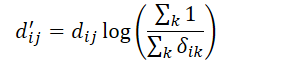

In [11]:
class Transfer_Complement_NaiveBayes():
    
    def __init__(self, df, new_df):
        self.df = df
        self.new_df = new_df
        self.instances_num = df.shape[0]
        self.J = 0
        
    def transfer_docfre_count_(self):
        """
        count all words in df
        input: df with clean column
        output: cnt dictionary of word list
        """
        cnt = collections.Counter()
        for word in self.df['clean'].values:
            for i in word:
                cnt[i] += 1
        
        cnt3 = collections.Counter()
        for words in self.df['clean'].values:
            for i in cnt.keys():
                if i in words:
                    cnt3[i]+=1
        self.count_attributes_docfre = cnt3
        
        cnt4 = collections.Counter()
        for word in self.df['clean'].values:
            for i in word:
                cnt4[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i]) # instead of add 1 every time meet a word, add another weight
        self.count_attributes = cnt4
        

 
    def count_class(self):
        """
        count the number of class labels
        input: df with class
        output: cnt dictionary of label
        """
        cnt2 = collections.Counter()
        for i in self.df['class'].values:
            cnt2[i] += 1
        self.count_class = dict(cnt2)


    def count_prior(self):
        """
        count the frequency of words in each class, return a dictionary(four class) of dictionary(words and freqeuncy)
        input: df with class and clean column
        output: list with four lists each for a class
        """
        result_list = {}
        cnt_A = collections.Counter()
        cnt_B = collections.Counter()
        cnt_V = collections.Counter()
        cnt_E = collections.Counter()
        for i in range(len(self.df['class'].values)):
            if self.df['class'].values[i] == 'A':
                for i in self.df['clean'].values[i]:
                    cnt_A[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
            elif self.df['class'].values[i] == 'B':
                for i in self.df['clean'].values[i]:
                    cnt_B[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
            elif self.df['class'].values[i] == 'E':
                for i in self.df['clean'].values[i]:
                    cnt_E[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
            elif self.df['class'].values[i] == 'V':
                for i in self.df['clean'].values[i]:
                    cnt_V[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
        result_list['A'] = cnt_A
        result_list['B'] = cnt_B
        result_list['E'] = cnt_E
        result_list['V'] = cnt_V

        self.count_prior =  result_list
    
   
    def count_class_attributes(self):
        """
        count how many words in class[A|B|E|V]
        input:
        output: list of class and number of list
        """
        class_attributes = {}
        for i in ['A','B','V','E']:
            class_attributes[i] = sum(self.count_prior[i].values())
            self.J += len(self.count_prior[i].keys())
        self.count_class_attributes = class_attributes
        self.total_num_words = sum(self.count_class_attributes.values())
    

        
    def predict_complement_naive(self,mu):
        """
        predict the posterior probability based on complement naive bayes
        output: a list of predicting labels
        """
        prob2 = {}
        result2 = []
        for i in range(len(self.new_df['abstract'])):
            a2, b2, e2, v2 = 0, 0, 0, 0
            for j in self.new_df['clean'].values[i]:
                a2 -= math.log(self.count_attributes[j]-self.count_prior['A'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['A']+mu*self.J)                                                                                                                                                                                                                                                         # 分子
                b2 -= math.log(self.count_attributes[j]-self.count_prior['B'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['B']+mu*self.J) 
                e2 -= math.log(self.count_attributes[j]-self.count_prior['E'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['E']+mu*self.J) 
                v2 -= math.log(self.count_attributes[j]-self.count_prior['V'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['V']+mu*self.J) 
            prob2['A'] = (a2)+math.log(self.count_class['A']) 
            prob2['B'] = (b2)+math.log(self.count_class['B']) 
            prob2['E'] = (e2)+math.log(self.count_class['E']) 
            prob2['V'] = (v2)+math.log(self.count_class['V']) 
            result2.append(max(prob2,key=prob2.get))
        self.predict_label_cnb = result2
       

In [12]:
tcnb = Transfer_Complement_NaiveBayes(X_train, X_test)
tcnb.transfer_docfre_count_()

tcnb.count_class()
tcnb.count_prior()
tcnb.count_class_attributes()
tcnb.predict_complement_naive(1)
print("TCNB accuracy is: ",cal_accuracy(tcnb.predict_label_cnb, y_test.values))


TCNB accuracy is:  0.9825


## Transform by the length of the doc

In [60]:
class Transfer_2nd_Complement_NaiveBayes():
    
    def __init__(self, df, new_df):
        self.df = df
        self.new_df = new_df
        self.instances_num = df.shape[0]
        self.J = 0
        
    def transfer_2nd_docfre_count_(self):
        """
        count all words in df
        input: df with clean column
        output: cnt dictionary of word list
        """
        cnt = collections.Counter()
        for word in self.df['clean'].values:
            for i in word:
                cnt[i] += 1
                
                
        cnt3 = collections.Counter()
        for words in self.df['clean'].values:
            for i in cnt.keys():
                if i in words:
                    cnt3[i]+=1
        self.count_attributes_docfre = cnt3
        
        cnt5 = collections.Counter()
        cnt6 = collections.Counter()
        for words in self.df['clean'].values:
            for i in words:
                cnt5[i]+=1
            print(cnt5,type(cnt5),list(cnt5.values()),type(list(cnt5.values())))
            cnt6[words] = math.sqrt(sum((np.array(list(cnt5.values())))**2))
            cnt5 = collections.Counter()
        self.cnt5 = cnt5
        self.count_attributes_doclen = cnt6
        
        cnt4 = collections.Counter()
        for word in self.df['clean'].values:
            for i in word:
                cnt4[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])/count_attributes_doclen[words] # instead of add 1 every time meet a word, add another weight
        self.count_attributes = cnt4
        

 
    def count_class(self):
        """
        count the number of class labels
        input: df with class
        output: cnt dictionary of label
        """
        cnt2 = collections.Counter()
        for i in self.df['class'].values:
            cnt2[i] += 1
        self.count_class = dict(cnt2)


    def count_prior(self):
        """
        count the frequency of words in each class, return a dictionary(four class) of dictionary(words and freqeuncy)
        input: df with class and clean column
        output: list with four lists each for a class
        """
        result_list = {}
        cnt_A = collections.Counter()
        cnt_B = collections.Counter()
        cnt_V = collections.Counter()
        cnt_E = collections.Counter()
        for i in range(len(self.df['class'].values)):
            if self.df['class'].values[i] == 'A':
                for i in self.df['clean'].values[i]:
                    cnt_A[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
            elif self.df['class'].values[i] == 'B':
                for i in self.df['clean'].values[i]:
                    cnt_B[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
            elif self.df['class'].values[i] == 'E':
                for i in self.df['clean'].values[i]:
                    cnt_E[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
            elif self.df['class'].values[i] == 'V':
                for i in self.df['clean'].values[i]:
                    cnt_V[i] += 1*math.log(self.instances_num/self.count_attributes_docfre[i])
        result_list['A'] = cnt_A
        result_list['B'] = cnt_B
        result_list['E'] = cnt_E
        result_list['V'] = cnt_V

        self.count_prior =  result_list
    
   
    def count_class_attributes(self):
        """
        count how many words in class[A|B|E|V]
        input:
        output: list of class and number of list
        """
        class_attributes = {}
        for i in ['A','B','V','E']:
            class_attributes[i] = sum(self.count_prior[i].values())
            self.J += len(self.count_prior[i].keys())
        self.count_class_attributes = class_attributes
        self.total_num_words = sum(self.count_class_attributes.values())
    

        
    def predict_complement_naive(self,mu):
        """
        predict the posterior probability based on complement naive bayes
        output: a list of predicting labels
        """
        prob2 = {}
        result2 = []
        for i in range(len(self.new_df['abstract'])):
            a2, b2, e2, v2 = 0, 0, 0, 0
            for j in self.new_df['clean'].values[i]:
                a2 -= math.log(self.count_attributes[j]-self.count_prior['A'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['A']+mu*self.J)                                                                                                                                                                                                                                                         # 分子
                b2 -= math.log(self.count_attributes[j]-self.count_prior['B'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['B']+mu*self.J) 
                e2 -= math.log(self.count_attributes[j]-self.count_prior['E'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['E']+mu*self.J) 
                v2 -= math.log(self.count_attributes[j]-self.count_prior['V'][j]+mu) - math.log(self.total_num_words-self.count_class_attributes['V']+mu*self.J) 
            prob2['A'] = (a2)+math.log(self.count_class['A']) 
            prob2['B'] = (b2)+math.log(self.count_class['B']) 
            prob2['E'] = (e2)+math.log(self.count_class['E']) 
            prob2['V'] = (v2)+math.log(self.count_class['V']) 
            result2.append(max(prob2,key=prob2.get))
        self.predict_label_cnb = result2
       

In [61]:
nb = Transfer_2nd_Complement_NaiveBayes(X, X)
nb.transfer_2nd_docfre_count_()
'''
nb.count_class()
nb.count_prior()
nb.count_class_attributes()
nb.predict_naive(1)
print("NB accuracy is: ",cal_accuracy(nb.predict_label, y_test.values))
'''

Counter({'genome': 5, 'c-125': 4, 'halodurans': 3, 'cdss': 3, 'bacillus': 2, 'contains': 2, 'protein': 2, 'sequences': 2, 'conserved': 2, 'function': 2, 'match': 2, 'proteins': 2, 'found': 2, 'bsubtilis': 2, 'b': 2, 'genes': 2, 'role': 2, 'competence': 2, 'tupa': 2, '4': 1, '202': 1, '353': 1, 'bp': 1, 'alkaliphilic': 1, 'bacterium': 1, '4066': 1, 'predicted': 1, 'coding': 1, '2141': 1, '527': 1, 'functional': 1, 'assignments': 1, '1182': 1, '29': 1, 'unknown': 1, '743': 1, '18': 1, '3': 1, 'database': 1, 'among': 1, 'total': 1, '88': 1, 'subtilis': 1, '667': 1, 'widely': 1, 'comparison': 1, 'various': 1, 'organisms': 1, 'including': 1, '112': 1, 'transposase': 1, 'indicating': 1, 'transposases': 1, 'played': 1, 'important': 1, 'evolutionary': 1, 'horizontal': 1, 'gene': 1, 'transfer': 1, 'also': 1, 'internal': 1, 'genetic': 1, 'rearrangement': 1, 'strain': 1, 'lacks': 1, 'necessary': 1, 'coms': 1, 'srfa': 1, 'rapc': 1, 'supporting': 1, 'fact': 1, 'demonstrated': 1, 'experimentally': 1

TypeError: unhashable type: 'list'

## Ten cross-validation

#### NB

In [13]:
def ten_CV_nb(df, split_size= 0.3, num_times = 10, num_folds=10):
    X, y = df,df['class']
    nb_res_list = []
    random_seeds = [int(x) for x in np.random.uniform(0, 10000, num_times)]
    for i in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=i)
        nb = NaiveBayes(X_train, X_test)
        nb.count_attributes()
        nb.count_class()
        nb.count_prior()
        nb.count_class_attributes()
        nb.predict_naive(1)
        nb_res_list.append(cal_accuracy(nb.predict_label, y_test.values))
    return np.mean(nb_res_list), np.var(nb_res_list)
        

In [14]:
print('The accuracy of Simple NB is %s and the variance is %s'%ten_CV_nb(df))

The accuracy of Simple NB is 0.9443333333333334 and the variance is 4.427777777777777e-05


#### CNB

In [15]:
def ten_CV_cnb(df, split_size= 0.3, num_times = 10, num_folds=10):
    X, y = df,df['class']
    cnb_res_list = []
    random_seeds = [int(x) for x in np.random.uniform(0, 10000, num_times)]
    for i in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=i)
        cnb = Complement_NaiveBayes(X_train, X_test)
        cnb.count_attributes()
        cnb.count_class()
        cnb.count_prior()
        cnb.count_class_attributes()
        cnb.predict_complement_naive(1)
        cnb_res_list.append(cal_accuracy(cnb.predict_label_cnb, y_test.values))
    return np.mean(cnb_res_list), np.var(cnb_res_list)
        

In [16]:
print('The accuracy of Complement NB is %s and the variance is %s'%ten_CV_cnb(df))

The accuracy of Complement NB is 0.9605 and the variance is 4.8916666666666726e-05


#### TCNB

In [17]:
def ten_CV_tcnb(df, split_size= 0.3, num_times = 10, num_folds=10):
    X, y = df,df['class']
    tcnb_res_list = []
    random_seeds = [int(x) for x in np.random.uniform(0, 10000, num_times)]
    for i in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=i)
        tcnb = Transfer_Complement_NaiveBayes(X_train, X_test)
        tcnb.transfer_docfre_count_()

        tcnb.count_class()
        tcnb.count_prior()
        tcnb.count_class_attributes()
        tcnb.predict_complement_naive(1)
        tcnb_res_list.append(cal_accuracy(tcnb.predict_label_cnb, y_test.values))
    return np.mean(tcnb_res_list), np.var(tcnb_res_list)
        

In [18]:
print('The accuracy of Transfer Complement NB is %s and the variance is %s'%ten_CV_tcnb(df))

The accuracy of Transfer Complement NB is 0.9658333333333333 and the variance is 1.444444444444439e-05


## Save the result to .csv file

In [19]:
import copy
tcnb = Transfer_Complement_NaiveBayes(df, new_df)
tcnb.transfer_docfre_count_()
tcnb.count_class()
tcnb.count_prior()
tcnb.count_class_attributes()
tcnb.predict_complement_naive(1)
new_df['class'] = tcnb.predict_label_cnb
result_df_simple = copy.deepcopy(new_df)
#result_df_simple.drop(["abstract"], axis = 1).drop(['clean'], axis = 1).to_csv("../data/tst_kaggle3_transfer_complement_tran.csv")

In [29]:
sum(np.array(list(cnb.count_class.values()))**2)

4618006

In [44]:
type(list(cnb.count_class.values()))

list

In [55]:
math.sqrt(sum(np.array((list(dict(cnb.count_attributes).values())))**2))

13321.003753471432